
# Getting Started: Daily & Monthly Flux Footprints

This notebook shows how to use **`ffp_daily_monthly_helper.py`** to:
1) load AmeriFlux half‑hourly data,  
2) compute an xarray-based footprint climatology,  
3) summarize to daily/monthly periods (optionally ET‑weighted), and  
4) export **80%** source‑area contours to a GeoPackage or rasters to GeoTIFF.

References: `ffp_daily_monthly_helper.py`【8†source】 and `ffp_xr.py`【9†source】.



## Requirements

This workflow uses: `numpy`, `pandas`, `xarray`, `matplotlib`, and for exports `geopandas`, `pyproj`, `shapely`, `rasterio`.


In [1]:

# --- Imports ---
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sys

sys.path.append("../../src")

from fluxfootprints import (
    load_config,
    load_amf_df,
    build_climatology,
    summarize_periods,
    export_contours_gpkg,
    export_rasters_geotiff,
    export_contour_stats_csv,
)


## 1) Set Paths

Update these to point at your AmeriFlux config (`.ini`) and half‑hourly `.csv`.


In [2]:

ini_path = Path("./input_data/US-UTE.ini")
csv_path = Path("./input_data/US-UTE_HH_202406241430_202409251400.csv")

assert ini_path.exists(), f"Config not found: {ini_path}"
assert csv_path.exists(), f"CSV not found: {csv_path}"

out_dir = Path("ffp_outputs")
out_dir.mkdir(parents=True, exist_ok=True)



## 2) Load Configuration & Data
`load_config` parses a minimal INI for site metadata and column mappings.  
`load_amf_df` reads the CSV, parses timestamps, sets the index to time, and replaces missing value sentinels【8†source】.


In [3]:

cfg = load_config(str(ini_path))
cfg


{'station_latitude': 37.7353,
 'station_longitude': -111.5708,
 'missing_data_value': -9999.0,
 'skiprows': 0,
 'date_parser': '%Y%m%d%H%M',
 'ts_col': 'TIMESTAMP_START',
 'wind_dir_col': 'WD',
 'wind_spd_col': 'WS',
 'ustar_col': 'USTAR',
 'mo_length_col': 'MO_LENGTH',
 'v_sigma_col': 'V_SIGMA'}

In [5]:

df = load_amf_df(str(csv_path), cfg)
display(df.head())
print("Time span:", df.index.min(), "→", df.index.max(), "| rows:", len(df))


,datetime_start,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,LE_SSITC_TEST,...,TA_1_2_1,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1
TIMESTAMP_START,,,,,,,,,,,,,,,,,,,,,
2024-06-24 14:30:00,2024-06-24 14:30:00,202406241500,427.0199,0.628133,17.26862,1.019290,0.069210,NaN,156.40850,NaN,...,29.95141,33.26877,12.052600,30.32464,33.45364,12.46181,30.06976,1665.4670,25.72815,22.44161
2024-06-24 15:00:00,2024-06-24 15:00:00,202406241530,425.9499,1.019297,15.18936,0.703052,0.285446,NaN,138.30920,NaN,...,30.02516,29.22197,10.155240,30.35956,29.77183,10.72635,30.13765,1765.9350,25.52736,22.41975
2024-06-24 15:30:00,2024-06-24 15:30:00,202406241600,426.4163,1.965228,14.87533,0.808026,1.081928,NaN,154.11530,NaN,...,30.24634,28.28498,9.838229,30.69433,28.63222,10.41335,30.40344,1495.7350,25.12511,22.32785
2024-06-24 16:00:00,2024-06-24 16:00:00,202406241630,426.0534,2.665907,15.61140,1.002919,0.519664,NaN,135.56180,NaN,...,30.75179,28.75255,10.538220,31.14621,29.16225,11.09066,30.90061,1491.0620,24.63557,22.18172
2024-06-24 16:30:00,2024-06-24 16:30:00,202406241700,427.8476,1.102921,15.21034,0.703084,1.147608,NaN,95.06287,NaN,...,29.16274,30.77158,10.165810,29.57434,30.96792,10.63069,29.30510,341.9711,24.14865,22.03216


Time span: 2024-06-24 14:30:00 → 2024-09-25 13:30:00 | rows: 4463



## 3) Build the Footprint Climatology
`build_climatology` renames expected AMF columns (WD, WS, USTAR, MO_LENGTH, V_SIGMA) to the solver’s names and runs the **xarray-based** climatology (`ffp_xr.ffp_climatology_new.run()`), filling `clim.f_2d` with per‑timestep footprints【8†source】【9†source】.


In [6]:

clim = build_climatology(
    df,
    crop_height=0.2,
    atm_bound_height=2000.0,
    inst_height=2.5,
    dx=10.0, dy=10.0,
    domain=(-500.0, 500.0, -500.0, 500.0),  # smaller domain for a quick start
)
clim


c:\Users\paulinkenbrandt\.conda\envs\py313\Lib\site-packages\xarray\core\computation.py:824: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)



## 4) Summarize to Daily / Monthly
- `summarize_periods` normalizes each time slice so that the sum over x,y = 1 (optional), then computes:
  - **Daily/Monthly means**, and
  - **ET‑weighted** versions using ET derived from LE (mm/hr = LE / 680.6)【8†source】.


In [7]:

summaries = summarize_periods(
    clim,
    df,
    et_source="LE",            # use LE (W/m^2) to derive ET weights
    daily=True,
    monthly=True,
    normalize_each_time=True,
)
summaries


SummaryResult(f_daily_mean=<xarray.DataArray (time: 94, x: 101, y: 101)> Size: 8MB
array([[[3.58529140e-25, 2.47120712e-25, 1.30180180e-25, ...,
         1.15227703e-06, 1.12684997e-06, 1.10643026e-06],
        [1.61688067e-24, 1.13370153e-24, 6.17743647e-25, ...,
         1.17094169e-06, 1.13943374e-06, 1.11496572e-06],
        [8.02980544e-24, 5.72022119e-24, 3.21445865e-24, ...,
         1.19367042e-06, 1.15319902e-06, 1.12281202e-06],
        ...,
        [7.89861902e-07, 8.66178271e-07, 9.85317157e-07, ...,
         1.91956888e-09, 1.24349142e-09, 8.91069420e-10],
        [8.39947197e-07, 9.18133265e-07, 1.03986243e-06, ...,
         2.39246383e-09, 1.56477140e-09, 1.13021861e-09],
        [8.73933879e-07, 9.53281685e-07, 1.07660354e-06, ...,
         2.75318461e-09, 1.81129648e-09, 1.31460274e-09]],

       [[6.00464387e-08, 6.93686910e-08, 8.59536570e-08, ...,
         8.36127401e-07, 7.71296111e-07, 7.25343010e-07],
        [5.76548590e-08, 6.56121274e-08, 8.00248469e-08, ...,



## 5) Quick Visualization

Plot the first available **daily mean** footprint.  
(Uses `matplotlib`; ensure you keep a single plot per figure and default colors.)


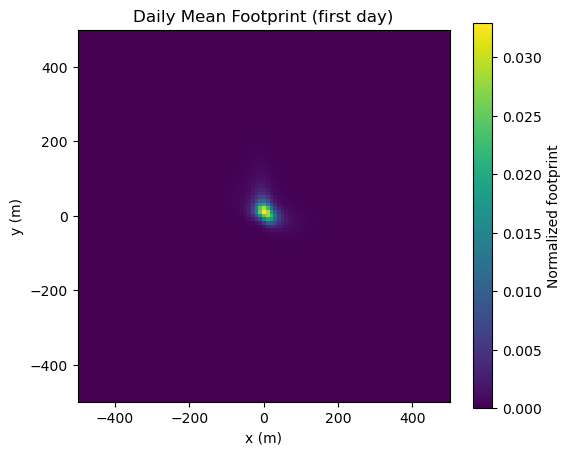

In [8]:

# pick the first day with data
da = summaries.f_daily_mean.isel(time=0)
plt.figure(figsize=(6, 5))
im = plt.imshow(da.values, origin="lower",
                extent=[float(clim.x.min()), float(clim.x.max()),
                        float(clim.y.min()), float(clim.y.max())])
plt.colorbar(im, label="Normalized footprint")
plt.title("Daily Mean Footprint (first day)")
plt.xlabel("x (m)"); plt.ylabel("y (m)")
plt.show()



## 6) Export 80% Contours to a GeoPackage

Writes layers like: `daily_mean_r80`, `monthly_etw_r80`, etc.  
Contours are generated with a robust alternative to `plt.contour` that can use `skimage` or `rasterio`【8†source】.


In [9]:

gpkg_path = out_dir / "footprints_80pct.gpkg"
gpkg_written = export_contours_gpkg(
    clim,
    summaries,
    df=df,
    station_lat=cfg["station_latitude"],
    station_lon=cfg["station_longitude"],
    gpkg_path=str(gpkg_path),
    crs_out="auto",            # chooses a suitable UTM
    levels=(0.8,),             # export the 80% source-area contour
    contour_method="auto",
)
print("GeoPackage written to:", gpkg_written)


GeoPackage written to: ffp_outputs\footprints_80pct.gpkg



## 7) Export GeoTIFF Rasters

Each time slice (daily/monthly) is written as a separate `.tif` with correct georeferencing around the tower origin【8†source】.


In [18]:

tif_dir = out_dir / "rasters"
export_rasters_geotiff(
    clim,
    summaries,
    station_lat=cfg["station_latitude"],
    station_lon=cfg["station_longitude"],
    out_dir=str(tif_dir),
    which=("daily_mean", "monthly_etw"),
    prefix="ffp",
)
tif_dir


WindowsPath('ffp_outputs/rasters')


## 8) Export Contour Stats to CSV

Creates a compact CSV with area (ha) and centroid (lat/lon) for each contour and time slice【8†source】.


In [10]:

csv_path = out_dir / "contour_stats.csv"
export_contour_stats_csv(
    df,
    clim,
    summaries,
    station_lat=cfg["station_latitude"],
    station_lon=cfg["station_longitude"],
    csv_path=str(csv_path),
    levels=(0.8,),
)
print("Stats CSV saved to:", csv_path)
pd.read_csv(csv_path).head()


Stats CSV saved to: ffp_outputs\contour_stats.csv


,layer,time,r,area_ha,centroid_lon,centroid_lat
0,daily_mean,2024-06-24T00:00:00,0.8,1.455,-111.570740,37.735527
1,daily_mean,2024-06-25T00:00:00,0.8,1.455,-111.570789,37.735509
2,daily_mean,2024-06-26T00:00:00,0.8,1.425,-111.570865,37.735552
3,daily_mean,2024-06-27T00:00:00,0.8,1.365,-111.570802,37.735390
4,daily_mean,2024-06-28T00:00:00,0.8,1.345,-111.570964,37.735380



## Tips & Troubleshooting

- If you see missing column errors, verify your CSV has the expected fields or update the INI to map the correct names. The helper expects AMF-like columns (e.g., `WD`, `WS`, `USTAR`, `MO_LENGTH`, `V_SIGMA`) and renames them internally【8†source】.
- ET weighting converts LE (W/m²) to mm/hr using `LE / 680.6`【8†source】.
- For exports, ensure `geopandas`, `shapely`, `pyproj`, and `rasterio` are installed.
- To change source-area levels, pass `levels=(0.5, 0.8)` to the export functions.
- To use a fixed CRS (instead of UTM auto), pass `crs_out=EPSG_CODE`.
